<span style="color:orange; font-weight:bold">Note: To answer questions based on text documents, we recommend the procedure in <a href="https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb">Question Answering using Embeddings</a>. Some of the code below may rely on <a href="https://github.com/openai/openai-cookbook/tree/main/transition_guides_for_deprecated_API_endpoints">deprecated API endpoints</a>.</span>

# 2. Creating a synthetic Q&A dataset
We use [`davinci-instruct-beta-v3`](https://beta.openai.com/docs/engines/instruct-series-beta), a model specialized in following instructions, to create questions based on the given context. Then we also use [`davinci-instruct-beta-v3`](https://beta.openai.com/docs/engines/instruct-series-beta) to answer those questions, given the same context.

This is expensive, and will also take a long time, as we call the davinci engine for each section. You can simply download the final dataset instead.

We're using the dataset created using the [previous notebook](olympics-1-collect-data.ipynb)

## 2.1 Read in the data, and create a context
Create a context by concatenating the title, the heading and the content of that section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
import configparser

config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/openapi.txt')
secret_key = config['global']['OPENAI_API_KEY']

In [13]:
import os
os.environ["OPENAI_API_KEY"] = secret_key # "sk-b..."

In [14]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DS-Data/olympics_sections.csv')
df['context'] = df.title + "\n" + df.heading + "\n\n" + df.content
df.head()

,title,heading,content,tokens,context
0,2020 Summer Olympics,Summary,The 2020 Summer Olympics (Japanese: 2020年夏季オリン...,716,2020 Summer Olympics\nSummary\n\nThe 2020 Summ...
1,2020 Summer Olympics,Host city selection,The International Olympic Committee (IOC) vote...,126,2020 Summer Olympics\nHost city selection\n\nT...
2,2020 Summer Olympics,Impact of the COVID-19 pandemic,"In January 2020, concerns were raised about th...",375,2020 Summer Olympics\nImpact of the COVID-19 p...
3,2020 Summer Olympics,Qualifying event cancellation and postponement,Concerns about the pandemic began to affect qu...,298,2020 Summer Olympics\nQualifying event cancell...
4,2020 Summer Olympics,Effect on doping tests,Mandatory doping tests were being severely res...,163,2020 Summer Olympics\nEffect on doping tests\n...


In [16]:
df=df.sample(5)

In [17]:
df.shape

(5, 5)

In [ ]:
df.columns

Index(['title', 'heading', 'content', 'tokens', 'context'], dtype='object')

## 2.2 Create questions based on the context
Use davinci-instruct to generate a number of plausible questions relating to the Wikipedia section contents.

Note: We have used temperature=0, but it may be beneficial to experiment with a higher temperature to get a higher diversity of questions.

<span style="color:orange; font-weight:bold">WARNING: This step will last a long time, and consume a lot of tokens, as it calls davinci-instruct for every section to generate a number of questions.</span>

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.1 MB/s eta 0:00:00


In [22]:
import openai
openai.api_key = secret_key
def get_questions(context):
    try:
      response = openai.Completion.create(
          engine="davinci-instruct-beta-v3",
          prompt=f"Write questions based on the text below\n\nText: {context}\n\nQuestions:\n1.",
          temperature=0,
          max_tokens=257,
          top_p=1,
          frequency_penalty=0,
          presence_penalty=0,
          stop=["\n\n"]
      )
      return response['choices'][0]['text']
    except:
        return ""


df['questions']= df.context.apply(get_questions)


In [23]:
df

,title,heading,content,tokens,context,questions
926,Football at the 2020 Summer Olympics – Men's t...,Squads,The men's tournament was an international tour...,169,Football at the 2020 Summer Olympics – Men's t...,What is the age restriction for players in th...
2345,2020 U.S. Olympic trials (gymnastics),Men's team,"The top all-around finisher, Brody Malone, was...",155,2020 U.S. Olympic trials (gymnastics)\nMen's t...,Who was the top all-around finisher? \n2. Who...
928,Football at the 2020 Summer Olympics – Men's t...,Group stage,The competing countries were divided into four...,69,Football at the 2020 Summer Olympics – Men's t...,How many teams competed in the men's football...
2428,Ukraine at the 2020 Summer Olympics,Shooting,Ukrainian shooters achieved quota places for t...,66,Ukraine at the 2020 Summer Olympics\nShooting\...,How many shooters from Ukraine achieved quota...
1771,Spain at the 2020 Summer Olympics,Golf,Spain entered four golfers (two per gender) in...,128,Spain at the 2020 Summer Olympics\nGolf\n\nSpa...,How many golfers did Spain enter into the Oly...


In [24]:
df['questions'] = "1." +df['questions']
df

,title,heading,content,tokens,context,questions
926,Football at the 2020 Summer Olympics – Men's t...,Squads,The men's tournament was an international tour...,169,Football at the 2020 Summer Olympics – Men's t...,1. What is the age restriction for players in ...
2345,2020 U.S. Olympic trials (gymnastics),Men's team,"The top all-around finisher, Brody Malone, was...",155,2020 U.S. Olympic trials (gymnastics)\nMen's t...,1. Who was the top all-around finisher? \n2. W...
928,Football at the 2020 Summer Olympics – Men's t...,Group stage,The competing countries were divided into four...,69,Football at the 2020 Summer Olympics – Men's t...,1. How many teams competed in the men's footba...
2428,Ukraine at the 2020 Summer Olympics,Shooting,Ukrainian shooters achieved quota places for t...,66,Ukraine at the 2020 Summer Olympics\nShooting\...,1. How many shooters from Ukraine achieved quo...
1771,Spain at the 2020 Summer Olympics,Golf,Spain entered four golfers (two per gender) in...,128,Spain at the 2020 Summer Olympics\nGolf\n\nSpa...,1. How many golfers did Spain enter into the O...


The prompt is designed to generate a number of questions. Example questions above were generated based on the summary section of the 2020 Summer Olympics page.

We can observe that the questions 3 and 5 above repeat. Sometimes the generated questions could be ambiguous without the context. We will show that even despite these limitations we can create a successful model.

In [ ]:
print(df.content.values[0])

The 2020 Summer Olympics (Japanese: 2020年夏季オリンピック, Hepburn: Nisen Nijū-nen Kaki Orinpikku), officially the Games of the XXXII Olympiad (第三十二回オリンピック競技大会, Dai Sanjūni-kai Orinpikku Kyōgi Taikai) and also known as Tokyo 2020 (東京2020, Tōkyō Nii Zero Nii Zero), was an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July 2021. Tokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina, on 7 September 2013.Originally scheduled to take place from 24 July to 9 August 2020, the event was postponed to 2021 on 24 March 2020 due to the global COVID-19 pandemic, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled). However, the event retained the Tokyo 2020 branding for marketing purposes. It was largely held behind closed doors with no public spectators permitted due to the declaration of a state of emergency in the Greater

## 2.3 Create answers based on the context
Use davinci-instruct to answer the questions given the relevant Wikipedia section contents

Note: We have used temperature=0, but it may be beneficial to experiment with a higher temperature to get a higher diversity of questions.

<span style="color:orange">**WARNING: This step will last a long time, and consume a lot of tokens, as it calls davinci-instruct for every section to answer all the questions.**</span>

In [ ]:
openai.api_key = secret_key
def get_answers(row):
    try:
        response = openai.Completion.create(
            engine="davinci-instruct-beta-v3",
            prompt=f"Write answer based on the text below\n\nText: {row.context}\n\nQuestions:\n{row.questions}\n\nAnswers:\n1.",
            temperature=0,
            max_tokens=257,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        return response['choices'][0]['text']
    except Exception as e:
        print (e)
        return ""


df['answers']= df.apply(get_answers, axis=1)
df['answers'] = "1." + df.answers
df = df.dropna().reset_index().drop('index',axis=1)
print(df[['answers']].values[0][0])

These are the answers to the questions above based on the context around the host city selection.

We can see that answers 3-5 contain the correct answer, but instead of answering the question directly, the answer is a verbatim extraction. Despite these occasional lower quality answers, we will show that the model can learn the task reasonably well, given a high number of examples.

In [ ]:
df.iloc[0]

title                                     2020 Summer Olympics
heading                                                Summary
content      The 2020 Summer Olympics (Japanese: 2020年夏季オリン...
tokens                                                     716
context      2020 Summer Olympics\nSummary\n\nThe 2020 Summ...
questions                                                   1.
answers      1. The 2020 Summer Olympics were an internatio...
Name: 0, dtype: object

In [ ]:
df['answers']= df.apply(get_answers, axis=1)
df['answers'] = "1." + df.answers
df = df.dropna().reset_index().drop('index',axis=1)
print(df[['answers']].values[0][0])

You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.
You exceeded your current quota, please check your plan and billing details.

KeyboardInterrupt: ignored

## 2.4 Save the Olympics Q&A dataset based on Wikipedia sections
We save the file for use in the [next notebook](olympics-3-train-qa.ipynb)

In [ ]:
df.to_csv('/content/drive/MyDrive/DS-Data/olympics_qa.csv', index=False)

## 2.5 Search file (DEPRECATED)
We create a search file ([API reference](https://beta.openai.com/docs/api-reference/files/list)), which can be used to retrieve the relevant context when a question is asked.

<span style="color:orange; font-weight:bold">DEPRECATED: The /search endpoint is deprecated in favour of using embeddings. Embeddings are cheaper, faster and can support a better search experience. See <a href="https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb">Question Answering Guide</a> for a search implementation using the embeddings</span>


In [ ]:
df = df[df.tokens<2000]
df[['context', 'tokens']].rename(columns={'context':'text','tokens':'metadata'}).to_json('/content/drive/MyDrive/DS-Data/olympics_search.jsonl', orient='records', lines=True)

search_file = openai.File.create(
  file=open("/content/drive/MyDrive/DS-Data/olympics_search.jsonl"),
  purpose='search'
)
olympics_search_fileid = search_file['id']

## 2.6 Answer questions based on the context provided

We will use a simple implementation of the answers endpoint. This works by simply using the [/search endpoint](https://beta.openai.com/docs/api-reference/searches), which searches over an indexed file to obtain the relevant sections which can be included in the context, following by a question and answering prompt given a specified model.

In [ ]:
from answers_with_ft import create_context, answer_question
print(create_context("Where did women's 4 x 100 metres relay event take place during the 2020 Summer Olympics?", olympics_search_fileid, max_len=400))

In [ ]:
answer_question(olympics_search_fileid, "davinci-instruct-beta-v3",
            "Where did women's 4 x 100 metres relay event take place during the 2020 Summer Olympics?")

After we fine-tune the model for Q&A we'll be able to use it instead of [`davinci-instruct-beta-v3`](https://beta.openai.com/docs/engines/instruct-series-beta), to obtain better answers when the question can't be answered based on the context. We see a downside of [`davinci-instruct-beta-v3`](https://beta.openai.com/docs/engines/instruct-series-beta), which always attempts to answer the question, regardless of the relevant context being present or not. (Note the second question is asking about a future event, set in 2024.)

In [ ]:
answer_question(olympics_search_fileid, "davinci-instruct-beta-v3",
            "Where did women's 4 x 100 metres relay event take place during the 2048 Summer Olympics?", max_len=1000)

' Japan National Stadium'

We can see that davinci has a tendency to answer the question, even if the question can't be answered given the context provided. Note the question asked regarding 2048 Summer Olympics, which didn't happen yet, and the retrieved content has only returned results for 2020.

## 2.7 (Optional) Investigation into how likely the search endpoint is to return the relevant context

In [ ]:
def check_context(title, heading, question, max_len=1800, search_model='ada', max_rerank=10):
    """
    Evaluate the performance of the search model in retrieving the correct context

    Parameters
    ----------
    title: str
        The title of the Wikipedia page
    heading: str
        The heading of the Wikipedia section
    qusetion: str
        The question
    max_len: int
        The maximum length of the context
    search_model: str
        The search model to use - `ada` is most cost effective
    max_rerank: int
        The maximum number of reranking documents to use the search model on

    Returns
    -------
    rank: int
        The rank of the correct context
    token_length: int
        The number of tokens needed to obtain the correct context
    """

    try:
        results = openai.Engine(search_model).search(
            search_model=search_model,
            query=question,
            max_rerank=max_rerank,
            file=olympics_search_fileid,
            return_metadata=True
        )
        index=-1
        returns = []
        cur_len = 0
        for result in results['data']:
            cur_len += int(result['metadata']) + 4 # we add 4 tokens for the separator `\n\n###\n\n`
            if cur_len > max_len:
                break
            returns.append(result['text'])
            res = result['text'].split('\n')
            if res[0] == title and res[1] == heading:
                index = len(returns) - 1
                break
        return index, cur_len
    except Exception as e:
        #print (e)
        return []
print(check_context("Athletics at the 2020 Summer Olympics – Women's 4 × 100 metres relay", "Summary", "Where did women's 4 x 100 metres relay event take place during the 2020 Summer Olympics?", max_len=10000))

(0, 58)


We utilize the generated questions based on context to estimate how often we can retrieve the original context. These questions are noisy, so this is not a perfect estimate.

Our questions and answers are prefixed with numbered bullet points, however due to the way they were generated, they are missing the first number, hence we add "1." to the list of questions (and answers).

We calculate the rank of the section retrieved using ada search, and the number of tokens in the context needed to retrieve the relevant section in full.

In [ ]:
ada_results = df.apply(lambda x: [
                    check_context( x.title,
                                   x.heading,
                                   q[3:],     # remove the number prefix
                                   max_len=1000000, # set a large number to get the full context
                                   search_model='ada',
                                   max_rerank=200,
                                 )
                    for q in (x.questions).split('\n') # split the questions
                    if len(q) >10 # remove the empty questions
                ], axis=1)
ada_results.head()

0    [(132, 27104), (-1, 22939), (8, 2151), (2, 121...
1    [(4, 1737), (0, 130), (8, 744), (96, 17208), (...
2          [(0, 373), (0, 373), (-1, 40610), (1, 570)]
3            [(0, 302), (0, 302), (5, 968), (8, 1425)]
4                      [(0, 167), (0, 167), (2, 1442)]
Name: ada, dtype: object

In [ ]:
out = pd.concat([ada_results], axis=1)
out.columns = ['ada']
out.to_csv('olympics-data/search_engine_results.csv')

In [ ]:
def expand_lists(out):
    """
    Expand a pandas series containing lists into a series, where each list element becomes a value on its own

    Input is a row per paragraph, which has multiple questions
    Output is a row per question
    """
    cols = [pd.DataFrame(out[name].tolist()).stack().reset_index(level=1, drop=True).rename(name) for name in out.columns]
    return pd.concat(cols, axis=1)

out_expanded = expand_lists(out)
out_expanded['rank'] = out_expanded.ada.apply(lambda x: x[0] if x != [] else -2)
out_expanded['tokens'] = out_expanded.ada.apply(lambda x: x[1] if x != [] else -2)


In [ ]:
within_2k = (out_expanded.tokens < 2000).mean()
print(f"{within_2k*100:.1f}% of relevant paragraphs are retrieved within the first 2k tokens")

74.3% of relevant paragraphs are retrieved within the first 2k tokens


The relevant context can be obtained 74% of the time on this dataset

In [ ]:
outside_200 = (out_expanded['rank'] == -1).mean()
print(f"{outside_200*100:.1f}% of relevant paragraphs are not retrieved within the first 200 results")

7.4% of relevant paragraphs are not retrieved within the first 200 results


7.4% of the time, this is due to the keyword search part of the search algorithm not retrieving the relevant context within the first 200 results.
18.3% of the time this is due to the semantic search not placing the relevant context within the first 2000 tokens.

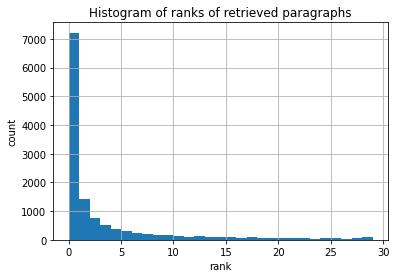

In [ ]:
import matplotlib.pyplot as plt

# plot a histogram, and add axis descriptions and title
out_expanded[(out_expanded['rank'] >=0)&(out_expanded['rank'] <30)]['rank'].hist(bins=29)
plt.xlabel('rank')
plt.ylabel('count')
plt.title('Histogram of ranks of retrieved paragraphs')
plt.show()

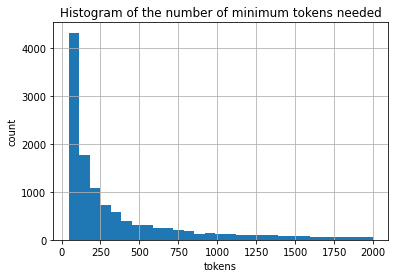

In [ ]:
out_expanded[(out_expanded.tokens>=0)&(out_expanded.tokens < 2000)]['tokens'].hist(bins=29)
plt.xlabel('tokens')
plt.ylabel('count')
plt.title('Histogram of the number of minimum tokens needed')
plt.show()

We can observe that the context is most likely to be returned as one of the first results, and most likely to be returned within the first 200-500 tokens.

In [ ]:
# normalized value_counts
out_expanded['rank'].value_counts(normalize=True).sort_index()[:13]

-2     0.000063
-1     0.074428
 0     0.453420
 1     0.089515
 2     0.047146
 3     0.032437
 4     0.024139
 5     0.019676
 6     0.015967
 7     0.013452
 8     0.011189
 9     0.009869
 10    0.009178
Name: rank, dtype: float64

probabilities of the relevant context being returned at each rank. (-2 means a processing error, -1 means the rank is >200)